# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [2]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [3]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [4]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [196]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):

    return np.mean(np.square(y_predicted - y_true))

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    u, v = 0, 0
    y_mean = 1/len(y_true) * (sum(y_true))
    for i in range(len(y_true)):
        u += (y_predicted[i] - y_true[i])**2
        v += (y_mean - y_true[i])**2  
        
    return (1 - u/v)

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [197]:
class NormalLR:
    def __init__(self):
        self.w = None
    
    def fit(self, X:np.ndarray, y:np.ndarray):
        X_new = X.copy()
        X_new = np.hstack((np.ones((X_new.shape[0], 1)), X_new))
        w = np.linalg.inv(X_new.T @ X_new) @ (X_new.T @ y)
        self.w = w
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        X_new = X.copy()
        X_new = np.hstack((np.ones((X_new.shape[0], 1)), X_new))
        return X_new @ self.w

In [198]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [199]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.01168333047554514, R2: 0.9974097657778892


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [281]:
class GradientLR:
            
    def oracle(self, w):
        
        return (1 / self.X.shape[0]) * (self.X.T @ (self.X @ w - self.y) + self.l * np.sign(w))
    
    def __init__(self, alpha:float, iterations=10000, l=0.):
        
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.oracle = GradientLR.oracle
        self.w = None
           
    def fit(self, X:np.ndarray, y:np.ndarray):
        X_new = X.copy()
        X_new = np.hstack((np.ones((X_new.shape[0], 1)), X_new))
        self.X = X_new
        self.y = y
        w = np.ones(X_new.shape[1])

        grad_start = np.linalg.norm(self.oracle(self, w))
        d = -self.oracle(self, w)
        
        for i in range(self.iterations):

            grad = self.oracle(self, w)
            if (np.linalg.norm(grad)**2 / (grad_start)**2) <= 1e-8:
                break
            else:
                d = -self.oracle(self, w)
                w = w + (self.alpha * d)

        self.w = w  
        return self.w
    
    def predict(self, X:np.ndarray): 
        X_new = X.copy()
        X_new = np.hstack((np.ones((X_new.shape[0], 1)), X_new))
        return X_new @ self.w
    
    @property
    def get_w_(self):
        return self.w[1:]

In [238]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.xlabel("xs")
    plt.ylabel("errors")
    plt.show()

In [239]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

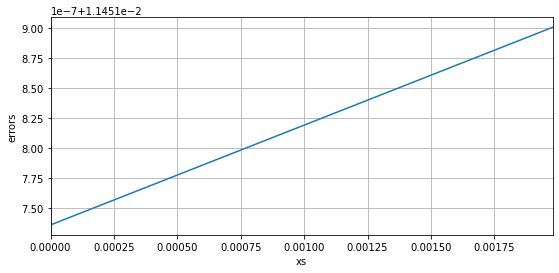

In [240]:
build_plot(X_train, y_train, X_val, y_val)

In [241]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009550439356752016, R2: 0.9986858454123442


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [283]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

x_max = np.amax(X_train, axis=0)
x_min = np.amin(X_train, axis=0)
y_min = np.min(y_train)
y_max = np.max(y_train)


def scaling_x(X, x_max = x_max, x_min = x_min):
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - x_min[j]) / (x_max[j] - x_min[j])
    return X
            
def scaling_y(y, y_min = y_min, y_max = y_max):
    for i in range(len(y)):
        y[i] = (y[i] - y_min) / (y_max - y_min)
    return y
        
X_train = scaling_x(X_train)
X_val = scaling_x(X_val)
y_train = scaling_y(y_train)
y_val = scaling_y(y_val)

In [284]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.01099570917572187, R2: 0.6872797475661067


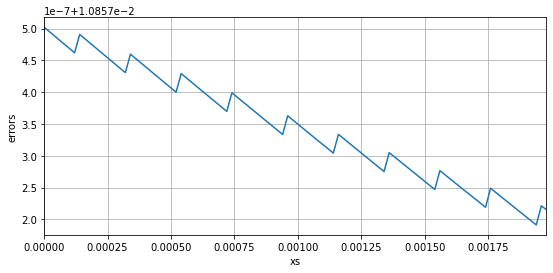

In [285]:
build_plot(X_train, y_train, X_val, y_val)

In [286]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 0.01099570917572187, R2: 0.6872797475661067


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [287]:
regr.get_w_

array([-0.09621189,  0.09276543,  0.01338171,  0.05081765, -0.13180825,
        0.52656581,  0.02466778, -0.26548462,  0.14226302, -0.16599952,
       -0.17034566,  0.10523938, -0.40504178])

##### Признаки, оказывающие влияние на стоимость недвижимости в Бостоне:

#####  1. crim     per capita crime rate by town
#####  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.
#####  3. indus    proportion of non-retail business acres per town
#####  4. chas     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
#####  5. nox      nitric oxides concentration (parts per 10 million)
##### 6. rm       average number of rooms per dwelling
##### 7. age      proportion of owner-occupied units built prior to 1940
##### 8. dis      weighted distances to five Boston employment centres
#####  9. rad      index of accessibility to radial highways
##### 10. tax      full-value property-tax rate per $10,000
##### 11. ptratio  pupil-teacher ratio by town
##### 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
##### 13. lstat    % lower status of the population

In [303]:
print("Соответсвующие признакам веса:", *regr.get_w_)

Соответсвующие признакам веса: -0.09621188747359852 0.09276542787381263 0.01338171486692185 0.05081765453463974 -0.13180824997976207 0.526565813357134 0.02466778194209056 -0.2654846170317435 0.1422630190352716 -0.16599952360079362 -0.170345657829398 0.10523938329000057 -0.40504177907014927
0.526565813357134


In [306]:
weights = regr.get_w_
for i, x in enumerate(weights):
    print(i, x)
print("max", max(weights))
print("min", min(weights))

0 -0.09621188747359852
1 0.09276542787381263
2 0.01338171486692185
3 0.05081765453463974
4 -0.13180824997976207
5 0.526565813357134
6 0.02466778194209056
7 -0.2654846170317435
8 0.1422630190352716
9 -0.16599952360079362
10 -0.170345657829398
11 0.10523938329000057
12 -0.40504177907014927
max 0.526565813357134
min -0.40504177907014927


Выводы:
- Положительные веса соответсвуют признакам, оказывающим влияние на повышение цены в Бостоне.
- Отрицательные веса говорят о том, что данные признаки оказывают влияние на ее цену.
- Видим, что 5 признак наиболее значим при увеличении цены. С ростом 12 признака цена снижается.